In [1]:
from PIL import Image 
import PIL
import os 
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from PIL import Image as im
import random

### Resizing the images into (150x150)

In [2]:
def resize_image(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img,(150,150))
    return img

### Getting dense-SIFT features

- Here step size is taken as 10
- This function return individual descriptors of each image and combined descriptors

In [3]:
def get_SIFT_features(images):
    sift = cv2.SIFT_create()
    descriptors_ind = np.empty((0,128), int)
    descriptors = []
    for image in images:
        step_size = 10
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image.shape[0], step_size) 
                                    for x in range(0, image.shape[1], step_size)]
        _,desc = sift.compute(image, kp)
        descriptors_ind = np.vstack((descriptors_ind, desc))
        descriptors.append(desc)
    descriptors = np.array(descriptors)
    return descriptors_ind, descriptors

### Reding the images

- This function takes input a folder name and reads all the images from it's subfodlers
- Return the resized images in the given folder

In [4]:
def get_images(folder_name,resize=False):
    images = []
    labels = []
    my_list = os.listdir(folder_name)
    for folder in my_list:
        if not folder.startswith("."):
            files = os.listdir(folder_name+"/"+folder)
            for file in files:
                if not file.startswith("."):
                    if resize:
                        img = resize_image(folder_name+"/"+folder+"/"+file)
                    else:
                        img = cv2.imread(folder_name+"/"+folder+"/"+file)
                    images.append(img)
                    labels.append(folder)
    return images,labels

### Getting kmeans model

- This function takes input number fo clusters and the descriptors
- Train the kmeans model 
- Return the trained model

In [5]:
def get_kmeans(n_clusters,descriptors_ind):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(descriptors_ind)
    return kmeans

### Get the histogram

- This function takes input a trained kmeans model, descriptors of all images
- Using the pre-trained kmeans model we can predict to which cluster given descriptor belongs to
- We can generate a histogram of size (number_of_images x number_of_clusters) and initialize with zeros
- While predicting to which cluster a descriptor of a certain image belongs to, we incerement the count of that particular index in the histogram 
- Returns the generated `histogram of visual words`

In [15]:
def get_histogram(kmeans,descriptors,n_clusters,images):
        
    hist_values = np.zeros((len(images),n_clusters), int)
    
    for i in range(len(images)):
        for j in range(len(descriptors[i])):
            cluster = kmeans.predict([descriptors[i][j]])
            hist_values[i][cluster[0]]+=1
            
    return hist_values

### Read the training images

In [6]:
folder_name =  '../dataset/SUN_data/SUN_data/train'
images, labels = get_images(folder_name, resize = True)

### Get SIFT features for training images

In [7]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  
descriptors_ind,descriptors =  get_SIFT_features(images)

### Get test images

In [8]:
folder_name =  '../dataset/SUN_data/SUN_data/test'
test_images, test_labels = get_images(folder_name, resize=True)

### Get SIFT features for test images

In [16]:
test_descriptors_ind,test_descriptors =  get_SIFT_features(test_images)

### Training the model 

- Get the kmeans model trained on training images descriptors
- Caluclate tf-idfs
- Normalize if needed
- Traing the linear SVM with the result of tf-idf
- Use this trained svm model to predict the labels of testing images
- Caluculate the confusion_matrix and accuracy_score

In [10]:
def training(n_clusters,c,normalise=False):
    
    ## get kmeans model
    kmeans = get_kmeans(n_clusters,descriptors_ind)
    
    ## calculate histogram of visual words
    hist_values = get_histogram(kmeans,descriptors,n_clusters,images)
       
    ## calculating tf
    tf = hist_values/hist_values.sum(axis=1, keepdims=True)
    
    ##calculating idf
    N = len(images)
    dfi = (hist_values != 0).sum(0)
    dfi= np.log(N/dfi)
    
    ## get tf_idf
    tf_idfs = np.multiply(tf,dfi)
    
    ## noramlizing the histogram
    if normalise:
        tf_idfs = normalize(tf_idfs, axis=0, norm='max')
     
    
    ## training SVM
    clf = OneVsRestClassifier(SVC(kernel="linear"))
    clf.fit(tf_idfs, labels)
    
    
    ## get histogram of visual words for test data
    test_hist_values = get_histogram(kmeans,test_descriptors,n_clusters,test_images)
        
    ## calculating tf
    tf_test = test_hist_values/test_hist_values.sum(axis=1, keepdims=True)
    
    ## calculate tf-idf for test data
    tf_idfs_test = np.multiply(tf_test,dfi)
    
    ## normalizing test data
    if normalise:
        tf_idfs_test = normalize(tf_idfs_test, axis=0, norm='max')
    
    ## predicting the labels 
    predicted_labels = clf.predict(tf_idfs_test)
    
    ## plot the confusion matrix and accuracy_score
    print(confusion_matrix(test_labels, predicted_labels))
    print(accuracy_score(test_labels, predicted_labels))
    
    
    return predicted_labels

In [11]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

clusters = [250,300,350]
predictions = []
for cluster in clusters:
    predictions.append(training(cluster,2))

[[ 7  3  1  0  2  2  4  1]
 [ 0 13  3  1  0  1  0  2]
 [ 0  6 12  0  0  1  0  1]
 [ 1  1  2 13  3  0  0  0]
 [ 0  1  0  0 16  0  3  0]
 [ 0  0  0  0  0 20  0  0]
 [ 3  1  0  1  2  8  4  1]
 [ 0  4  1  0  0  1  0 14]]
0.61875
[[ 4  3  0  0  2  6  4  1]
 [ 0 14  2  1  0  1  0  2]
 [ 0  8 11  0  0  0  0  1]
 [ 1  1  2 14  2  0  0  0]
 [ 1  0  0  2 14  0  2  1]
 [ 0  0  0  0  0 20  0  0]
 [ 3  1  0  0  1  8  6  1]
 [ 1  4  2  0  0  1  0 12]]
0.59375
[[ 8  3  1  0  2  3  2  1]
 [ 0 13  4  1  0  1  0  1]
 [ 0  7 11  1  1  0  0  0]
 [ 1  1  2 13  2  0  1  0]
 [ 0  0  0  2 15  0  3  0]
 [ 0  0  0  0  0 20  0  0]
 [ 4  1  0  0  1  6  6  2]
 [ 0  3  2  0  0  1  1 13]]
0.61875


#### Observation

- As we can observe that we got 61% accuracy with 250 clusters and 350 clusters
- Without normalizing and using tfidfs

In [12]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

clusters = [250,300,350]
predictions_normal = []
for cluster in clusters:
    predictions_normal.append(training(cluster,2,normalise=True))

[[ 8  1  1  0  2  3  1  4]
 [ 3 10  1  1  0  1  0  4]
 [ 0  5 12  0  0  1  0  2]
 [ 1  0  1 17  0  1  0  0]
 [ 1  1  0  2 10  0  6  0]
 [ 1  0  0  0  0 16  1  2]
 [ 5  1  1  0  2  4  4  3]
 [ 1  1  1  0  0  2  0 15]]
0.575
[[ 4  1  0  0  3  5  5  2]
 [ 1 12  1  1  0  0  1  4]
 [ 0  6 12  1  0  0  0  1]
 [ 1  0  2 12  4  1  0  0]
 [ 1  0  0  3 13  1  2  0]
 [ 2  0  0  0  0 16  0  2]
 [ 3  1  0  1  1  6  5  3]
 [ 1  2  1  1  0  0  0 15]]
0.55625
[[10  1  0  1  1  1  4  2]
 [ 2 12  2  1  0  0  1  2]
 [ 0  4 12  2  0  0  0  2]
 [ 3  0  1 14  1  0  1  0]
 [ 1  0  1  4 11  1  2  0]
 [ 0  0  0  2  0 16  1  1]
 [ 6  1  0  0  0  5  6  2]
 [ 0  1  1  1  0  0  1 16]]
0.60625


#### Observation

- We got 60% accuracy using 350 clusters
- Here we applied tfidfs and normalization

In [13]:
def show_images(arr, norm_pred, pred, actual):
    data = im.fromarray(arr)
    plt.imshow(data)
    plt.xticks([])
    plt.yticks([])
    s = "Actual label: "+str(actual)+"\nPredicted label without normalization:  "+str(pred)+"\nPredicted label with normalization:  "+str(norm_pred)
    plt.title(s)
    plt.show()

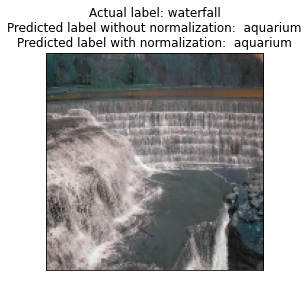

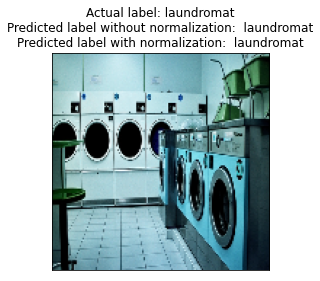

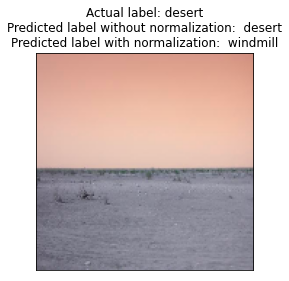

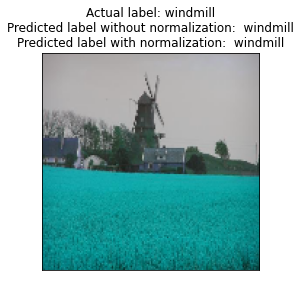

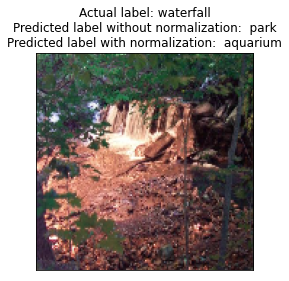

In [14]:
arr = random.sample(range(0, len(test_labels)), 5)
for i in arr:
    show_images(test_images[i], predictions_normal[0][i], predictions[1][i], test_labels[i])

#### Observation

- Above we have plotted few images with their actual labels and predicted lables
- We can see that few labels were correctly predict while few or not
- This is beacuse model is only 61% accurate with the given data